In [1]:
from kinematics.kinematics import KinematicsSolver
from joint_trajectories import SimpleJointSpaceTrajectory, MidpointsJointSpaceTrajectory
from utils import acquire_trajectory_functions
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib

# Initialize solvers - kinematics and trajectory

In [2]:
# Wszystkie wartości translacji w metrach
# Translacja mocowania - pomiędzy world frame, a J1
mount_t = np.array([0, 0, 0.05, 1])

# Translacja T1 - pomiędzy J1, a J2
t1 = np.array([0.05, 0, -0.035, 1])

# Translacja T2 - pomiędzy J2, a J3
t2 = np.array([0.09, 0, 0, 1])

# Translacja T3 - pomiędzy J3, a FCP
t3 = np.array([0.1, 0, 0, 1])


kinematics_solver = KinematicsSolver(mount_t, t1, t2, t3, 0, -np.pi/2)
trajectory_generator = SimpleJointSpaceTrajectory(kinematics_solver)

# Generate trajectory

In [12]:
start_coordinates = np.array([0, -0.02, -0.15])
end_coordinates = np.array([0, 0.02, -0.15])

velocity_start = np.array([0, 0, 0])
velocity_end = np.array([0, 0, 0])
time_end = 3

coefficients = trajectory_generator.generate_trajectory(start_coordinates, end_coordinates, velocity_start, velocity_end, time_end)

In [13]:
# Timesteps - update leg's position with frequency F=20Hz (every 50ms)
x = np.arange(0, time_end, 0.05)

In [14]:
j_pos = []
j_vel = []
j_accel = []

for coeffs in coefficients:
    pos_poly, vel_poly, accel_poly = acquire_trajectory_functions(coeffs)
    
    j_pos.append(pos_poly)
    j_vel.append(vel_poly)
    j_accel.append(accel_poly)

# Show trajectory for Joint1

In [15]:
positions = j_pos[0](x)
vels = j_vel[0](x)
accels = j_accel[0](x)

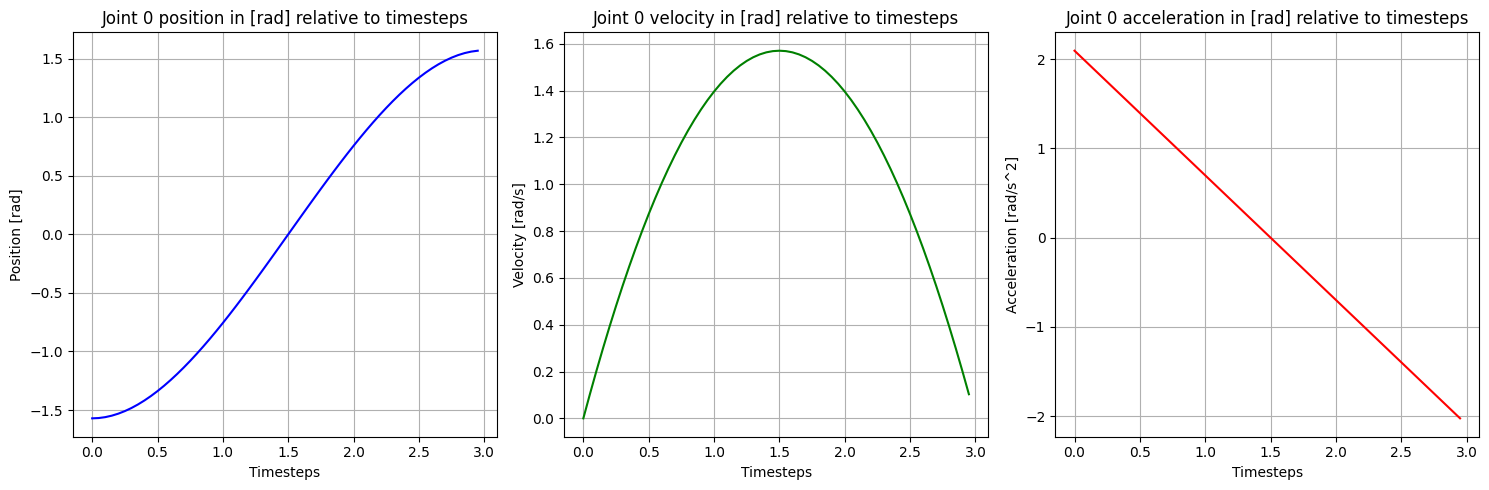

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot data on the first subplot
ax1.plot(x, positions, color='blue')
ax1.set_title("Joint 0 position in [rad] relative to timesteps")
ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Position [rad]")
ax1.grid()

# Plot data on the second subplot
ax2.plot(x, vels, color='green')
ax2.set_title("Joint 0 velocity in [rad] relative to timesteps")
ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Velocity [rad/s]")
ax2.grid()

# Plot data on the third subplot
ax3.plot(x, accels, color='red')
ax3.set_title("Joint 0 acceleration in [rad] relative to timesteps")
ax3.set_xlabel("Timesteps")
ax3.set_ylabel("Acceleration [rad/s^2]")
ax3.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Show trajectory of Foot Center Point in Cartesian coordinate system

In [8]:
x_points = []
y_points = []
z_points = []

theta1 = j_pos[0](x)
theta2 = j_pos[1](x)
theta3 = j_pos[2](x)
for i in range(len(x)):
    coordinates = kinematics_solver.forward(theta1[i], theta2[i], theta3[i])
    x_points.append(coordinates[0])
    y_points.append(coordinates[1])
    z_points.append(coordinates[2])

Text(0.5, 0, 'Z Axis')

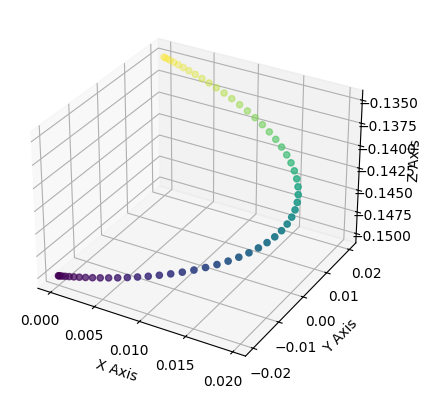

In [11]:
# Enable interactive plotting in PyCharm
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_points, y_points, z_points, c=z_points, marker='o')

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Generate trajectory in joint space with any number of midpoints

In [17]:
midpoints_trajectory = MidpointsJointSpaceTrajectory(kinematics_solver)

In [19]:
# 5 interpolation points (2 boundary points and 3 midpoints), each represented as subarray with values in x, y and z axis
coordinates = np.array([[0, -0.05, 0], [0.05, -0.02, 0.05], [0.05, 0, 0.06], [0.05, 0.02, 0.05], [0, 0.05, 0]])

# Boundary velocities (start and finish velocity) for each joint
velocities = np.array([[0,0], [0,0], [0,0]])

# Move times meaning time for each joint to move from currently starting point to the next point
move_times = np.array([1.5, 0.25, 0.25, 1.5])

# Time steps for whole movement probed with f=200Hz (T=5ms)
x = np.arange(0, sum(move_times), 0.005)

In [20]:
polys = midpoints_trajectory.generate_trajectory(coordinates, velocities, move_times)

## Position, velocity and acceleration plots for Joint 0

In [21]:
midtrajectory_positions = polys[0](x)
midtrajectory_vels = polys[0].get_velocity(x)
midtrajectory_accels = polys[0].get_acceleration(x)

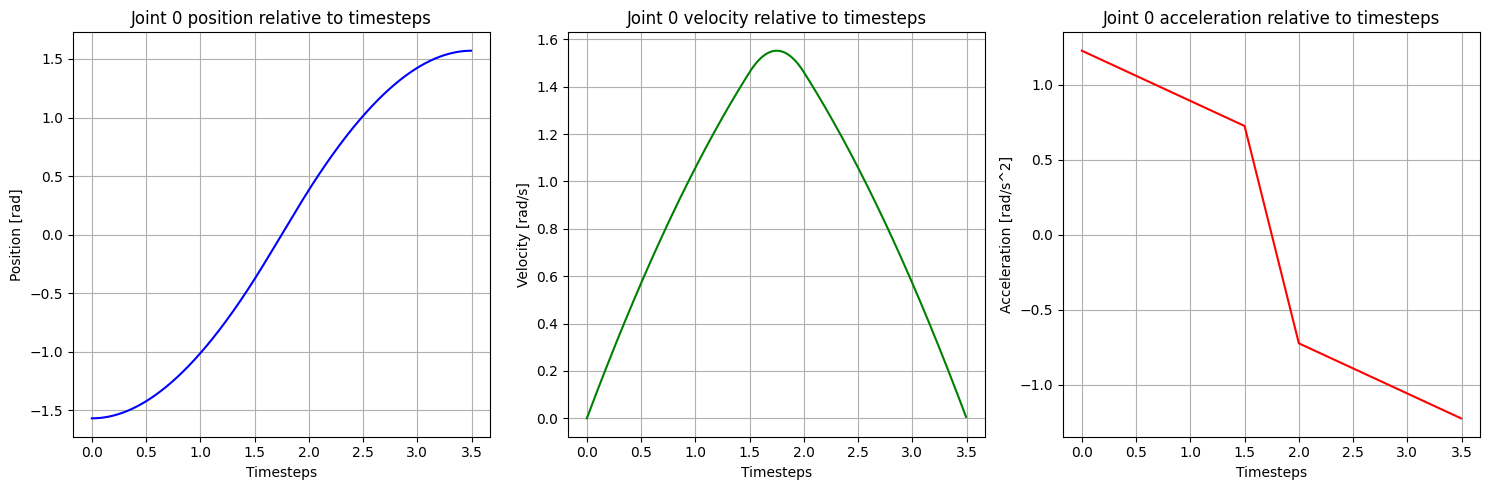

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot data on the first subplot
ax1.plot(x, midtrajectory_positions, color='blue')
ax1.set_title("Joint 0 position relative to timesteps")
ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Position [rad]")
ax1.grid()

# Plot data on the second subplot
ax2.plot(x, midtrajectory_vels, color='green')
ax2.set_title("Joint 0 velocity relative to timesteps")
ax2.set_xlabel("Timesteps")
ax2.set_ylabel("Velocity [rad/s]")
ax2.grid()

# Plot data on the third subplot
ax3.plot(x, midtrajectory_accels, color='red')
ax3.set_title("Joint 0 acceleration relative to timesteps")
ax3.set_xlabel("Timesteps")
ax3.set_ylabel("Acceleration [rad/s^2]")
ax3.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Trajectory in cartesian coordinate system

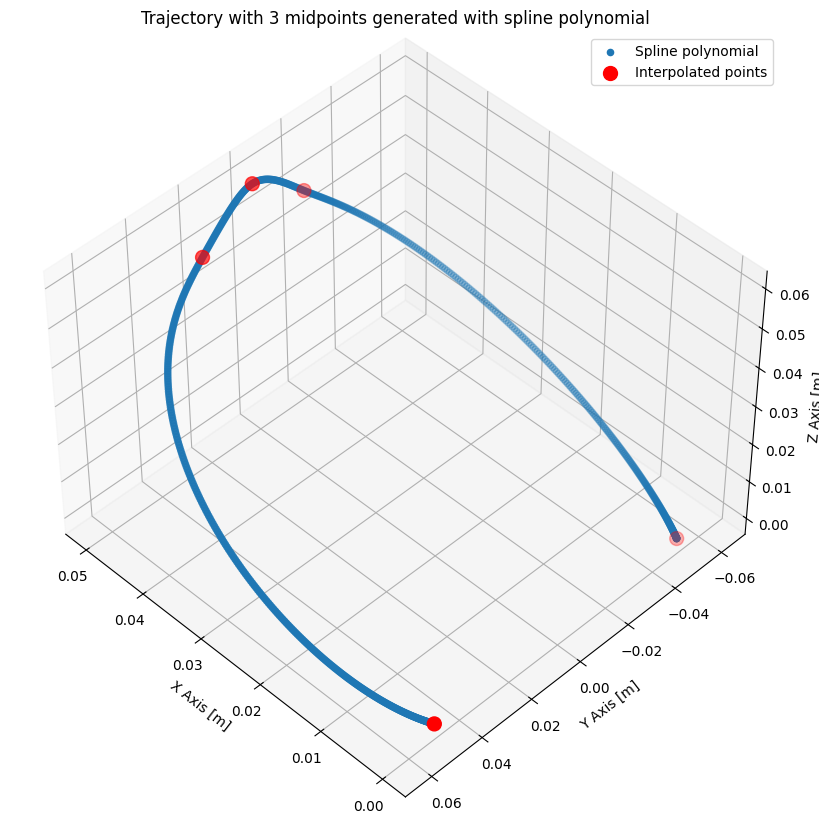

In [40]:
x_points = []
y_points = []
z_points = []

theta1 = polys[0](x)
theta2 = polys[1](x)
theta3 = polys[2](x)
for i in range(len(x)):
    forward_coordinates = kinematics_solver.forward(theta1[i], theta2[i], theta3[i])
    x_points.append(forward_coordinates[0])
    y_points.append(forward_coordinates[1])
    z_points.append(forward_coordinates[2])

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(label="Trajectory with 3 midpoints generated with spline polynomial")
scatter = ax.scatter(x_points, y_points, z_points, marker='o', label="Spline polynomial")
ax.view_init(elev=45, azim=135)
coordinate_points_x = [x[0] for x in coordinates]
coordinate_points_y = [x[1] for x in coordinates]
coordinate_points_z = [x[2] for x in coordinates]
ax.scatter(coordinate_points_x, coordinate_points_y, coordinate_points_z, color='red', s=100, label="Interpolated points")

# Add labels
ax.set_xlabel('X Axis [m]')
ax.set_ylabel('Y Axis [m]')
ax.set_zlabel('Z Axis [m]')
ax.legend()

# Show the interactive plot
plt.show()